First we generate the data the we train on. In this case a 1D burgers equation solver using a spectral fourier method. 

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftshift, fftfreq
from scipy.integrate import solve_ivp

#Creating data by solving the burgers equation in 1D
def init_KS(x,t=0):
    u = (1+np.sin(x/10))
    return u
def Fourier_n(u, Omega,n):
    u_hat = (1j*Omega)**n*fft(u)
    u_hat = ifft(u_hat)
    return u_hat

N = 300
L = 2
x = np.linspace(-L/2, L/2, N, endpoint=False)

n = fftfreq(N)*N
scale = 2*np.pi/L
Omega = scale*n
u0 = -np.sin(np.pi*x)

def burgers(u, Omega,nu):
    #dudt = -u*Fourier_n(u, Omega, 1)+nu*Fourier_n(u, Omega, 2)
    dudt = -0.5*Fourier_n(u*u, Omega, 1)+nu*Fourier_n(u, Omega, 2)
    return np.real(dudt)

tend = 0.3
tspan = [0, tend]
nu = 0.01/np.pi
t_len = 2000
tmeasurements = np.linspace(0, tend, t_len)
sol = solve_ivp(lambda t, u: burgers(u, Omega,nu),tspan, u0, t_eval=tmeasurements)
data = sol.y.T


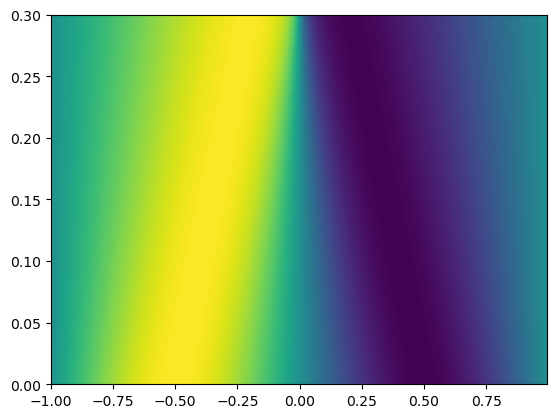

In [145]:
import numpy as np
import matplotlib.pyplot as plt
# data = np.load("burgers_solution.npy")
# x = np.load('Burgers_x.npy')
# t = np.load('Burgers_t.npy')
plt.figure()
plt.contourf(x,sol.t,data, 100, cmap="viridis")
# plt.plot(trajectory_1[:,0],trajectory_1[:,1], 'o', color = 'black', markersize = 2)
# plt.plot(trajectory_2[:,0],trajectory_2[:,1], 'o', color = 'black', markersize = 2)
plt.show()


## SHRED

Now we initialize the SHRED data setup. 

In [146]:
from pyshred import DataManager, SHRED, SHREDEngine, DeviceConfig
# import pyshred
manager = DataManager(
    lags=30,          # 
    train_size=0.8,   # 80% for training We take 80% from the start 0,1,2,3... 
    val_size=0.1,     # 10% for validation Then comes val 10% from where train ends.
    test_size=0.1     # 10% for testing Lastly comes test.
)

manager.add_data(
    data=data,         # Must have time as the first index of the data. 
    id="burger",          # Unique identifier for the dataset
    random=10,          # Randomly select 3 sensor locations
    compress=False     # Keep original spatial resolution (no compression)
)

# Prepare the datasets and get train, val and test
train_dataset, val_dataset, test_dataset= manager.prepare()

#initialize the SHRED model
shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)

DeviceConfig(device_type = 'cuda') # Set up device to use GPU


DeviceConfig(device_type='cuda', device_id=None, force_cpu=False, warn_on_fallback=True)

# Now we fit the model!

In [147]:
val_errors = shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=40,
    batch_size= 32,
    verbose = True,
)

train_mse = shred.evaluate(dataset=train_dataset) #Mse stands for mean over every element. It is the summed loss divided by the number of elements.
val_mse = shred.evaluate(dataset=val_dataset)
test_mse = shred.evaluate(dataset=test_dataset)
print(f"Train MSE: {train_mse:.3f}")
print(f"Val   MSE: {val_mse:.3f}")
print(f"Test  MSE: {test_mse:.3f}")

Fitting SHRED...
Epoch 1: Average training loss = 0.078843
Validation MSE (epoch 1): 0.041653
Epoch 2: Average training loss = 0.167448
Validation MSE (epoch 2): 0.107844
Epoch 3: Average training loss = 0.123481
Validation MSE (epoch 3): 0.028925
Epoch 4: Average training loss = 0.108836
Validation MSE (epoch 4): 0.096553
Epoch 5: Average training loss = 0.065494
Validation MSE (epoch 5): 0.017164
Epoch 6: Average training loss = 0.032032
Validation MSE (epoch 6): 0.013275
Epoch 7: Average training loss = 0.009751
Validation MSE (epoch 7): 0.006048
Epoch 8: Average training loss = 0.029335
Validation MSE (epoch 8): 0.006035
Epoch 9: Average training loss = 0.037161
Validation MSE (epoch 9): 0.005490
Epoch 10: Average training loss = 0.016920
Validation MSE (epoch 10): 0.004511
Epoch 11: Average training loss = 0.016994
Validation MSE (epoch 11): 0.006693
Epoch 12: Average training loss = 0.011946
Validation MSE (epoch 12): 0.006806
Epoch 13: Average training loss = 0.005412
Validation

# Training complete and we move to downstream tasks.

In [148]:
engine = SHREDEngine(manager, shred) #Initialize the SHRED engine used for downstream tasks

# obtain latent space of test sensor measurements
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

# generate latent states from validation sensor measurements
val_latents = engine.sensor_to_latent(manager.val_sensor_measurements)

# seed the forecaster with the final `seed_length` latent states from validation
init_latents = val_latents[-shred.latent_forecaster.seed_length:] # seed forecaster with final lag timesteps of latent space from val

# set forecast horizon to match the length of the test dataset
h = len(manager.test_sensor_measurements)

# forecast latent states for the test horizon
test_latent_from_forecaster = engine.forecast_latent(h=h, init_latents=init_latents)



In [149]:
# decode latent space generated from sensor measurements (generated using engine.sensor_to_latent())
test_reconstruction = engine.decode(test_latent_from_sensors)

# decode latent space generated by the latent forecaster (generated using engine.forecast_latent())
test_forecast = engine.decode(test_latent_from_forecaster)

In [150]:
# ---------------- Train Evaluation ----------------
t_train = len(manager.train_sensor_measurements)
train_Y = {"burger": data[0:t_train]}  # Ground truth segment
train_error = engine.evaluate(manager.train_sensor_measurements, train_Y)

# ---------------- Validation Evaluation ----------------
t_val = len(manager.val_sensor_measurements)
val_Y = {"burger": data[t_train:t_train + t_val]}
val_error = engine.evaluate(manager.val_sensor_measurements, val_Y)

# ---------------- Test Evaluation ----------------
t_test = len(manager.test_sensor_measurements)
test_Y = {"burger": data[-t_test:]}
test_error = engine.evaluate(manager.test_sensor_measurements, test_Y)

# ---------------- Print Results ----------------
print("---------- TRAIN ----------")
print(train_error)

print("\n---------- VALIDATION ----------")
print(val_error)

print("\n---------- TEST ----------")
print(test_error)

---------- TRAIN ----------
             MSE      RMSE       MAE        R2
dataset                                       
burger   0.00032  0.017875  0.013138  0.921043

---------- VALIDATION ----------
              MSE      RMSE       MAE        R2
dataset                                        
burger   0.000598  0.024459  0.011953 -38.87841

---------- TEST ----------
              MSE     RMSE       MAE         R2
dataset                                        
burger   0.003202  0.05659  0.038687 -357.28219


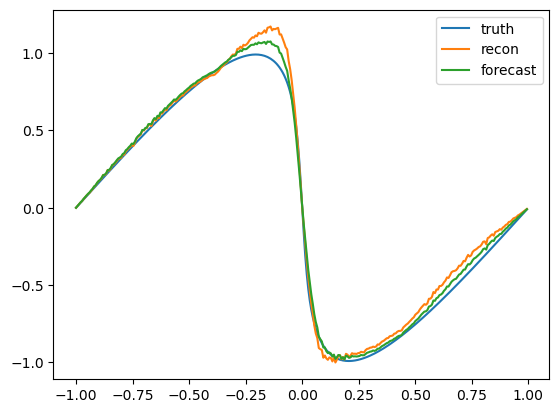

In [151]:
import matplotlib.pyplot as plt
import numpy as np

# Final ground truth frame from the test set
truth = data[-1]

# Extract final reconstructed frame (from sensor-based latents)
reconstructions = test_reconstruction["burger"]
reconstruction = reconstructions[h - 1]

# Extract final forecasted frame (from forecasted latents)
forecasts = test_forecast["burger"]
forecast = forecasts[h - 1]

# Collect data and labels for visualization
compare_data = [truth, reconstruction, forecast]
titles = ["Test Ground Truth", "SHRED Reconstruction", "SHRED Forecast"]


# Create side-by-side comparison plot
fig,ax = plt.subplots()
ax.plot(x,truth, label = 'truth')
ax.plot(x,reconstruction,label = 'recon')
ax.plot(x,forecast,label = 'forecast')
ax.legend()